# Описание проекта

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.
В качестве метрики используем RMSE. Удовлетворительным уровнем будет считаться, если метрика на тестовой выборке не будет превышать 48.

Порядок выполнения проекта:
1. Загрузим и подготовим данные, выполнив ресемплирование по одному часу.
2. Проанализируем данные
3. Обучим 2 модели: линейную регрессию и градиентный бустинг. Размер тестовой выборки составит 10% от всех данных.
4. Проверим качество моделей на тестовой выборке.
5. Сделаем выводы по проделанной работе.

## Описание данных

In [277]:
#import
import pandas as pd
import numpy as np
import phik

# Визуализация данных:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import warnings

warnings.filterwarnings('ignore')

## Загрузка данных:

Загрузим данные, после чего проверим корректность типов данных и наличие пропусков. Ресемплируем данные по одному часу, чтобы получить количество заказов такси в каждом часе.

In [278]:
# Загружаем данные
try:
    df = pd.read_csv('datasets/taxi.csv', parse_dates=['datetime'])
except FileNotFoundError:
    df = pd.read_csv('data/taxi.csv', parse_dates=['datetime'])

In [279]:
# Проверяем порядок и период дат
print(f'Первая строка датасета:             {df.loc[df.index[0], 'datetime']}')
print(f'Самая ранняя запись в датасете:     {df["datetime"].min()}\n\n')

print(f'Последняя строка датасета:          {df.loc[df.index[-1], 'datetime']}')
print(f'Самая поздняя запись в датасете:    {df["datetime"].max()}\n\n')

# Выводим датасет
df

Первая строка датасета:             2018-03-01 00:00:00
Самая ранняя запись в датасете:     2018-03-01 00:00:00


Последняя строка датасета:          2018-08-31 23:50:00
Самая поздняя запись в датасете:    2018-08-31 23:50:00




,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [280]:
 # Выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [281]:
# Ресемплируем данные
df = df.resample('1H', on='datetime').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [282]:
# Проверяем корректность
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Выводы:

- Период дат в датасете с 2018-03-01 по 2018-08-31.
- Данные загружены корректно, типы данных соответствуют ожидаемым.
- Пропусков в данных нет.
- Данные ресемплированы по одному часу, общее количество записей сократилось с 26 500 до 4 500
- Столбец `datetime` стал индексом, что позволит удобно работать с временными рядами.

## Исследовательский анализ данных:

Посмотрим на график количества заказов такси по часам, чтобы выявить тренды и сезонность. Также проверим наличие выбросов в данных.

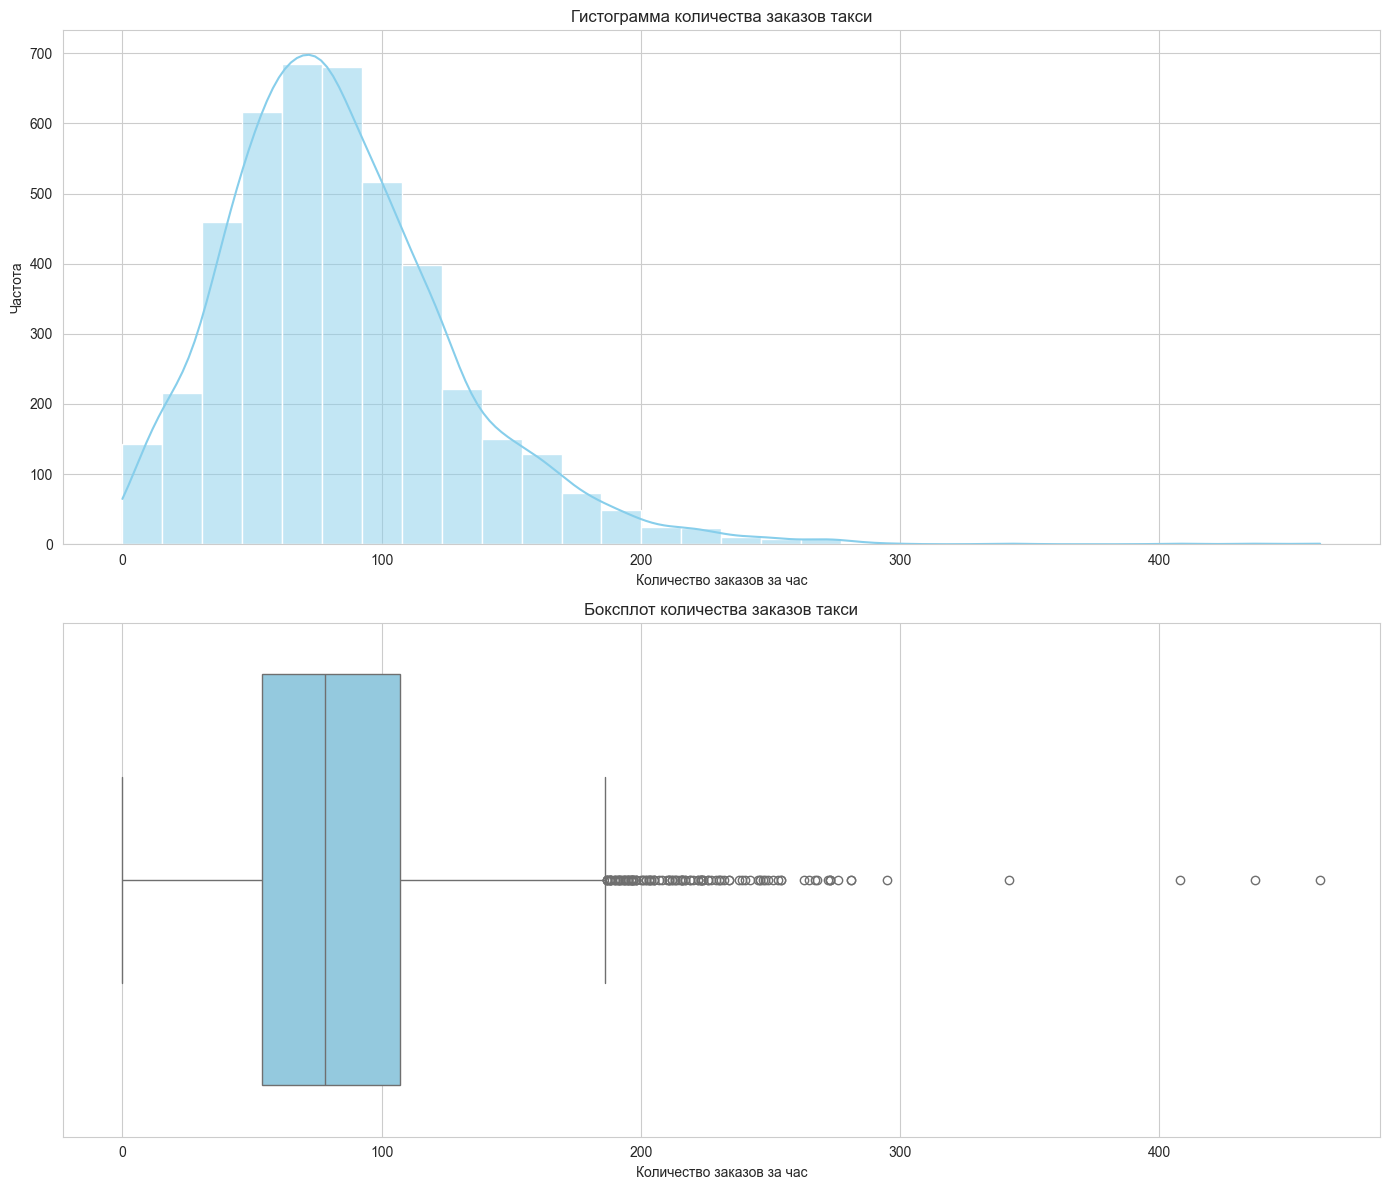

In [283]:
# Создаем фигуру с двумя подграфиками
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Создаем гистограмму для количества заказов
sns.histplot(data=df, x='num_orders', bins=30, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Гистограмма количества заказов такси')
ax[0].set_xlabel('Количество заказов за час')
ax[0].set_ylabel('Частота')

# Рисуем боксплот для количества заказов
sns.boxplot(data=df, x='num_orders', color='skyblue', ax=ax[1])
ax[1].set_title('Боксплот количества заказов такси')
ax[1].set_xlabel('Количество заказов за час')

# Отображаем графики
plt.tight_layout()
plt.show()

У нас есть выбросы, однако они находятся в пределах разумного. Количество заказов такси в час варьируется от 0 до 200 (в среднем 50-90 заказов).

Выделим из даты месяц, день, и день недели, после чего создадим сводные таблицы, чтобы провести более детальный анализ.

In [284]:
# Добавляем столбцы с месяцем, днем и днем недели
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

# Выводим датасет
df

,num_orders,month,day,day_of_week,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4
...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19
2018-08-31 20:00:00,154,8,31,4,20
2018-08-31 21:00:00,159,8,31,4,21


In [285]:
def draw_pivot_table(pivot_table,
                     title='Заголовок', xlabel='Ось Х',
                     label_dict={i: str(i) for i in range(32)}) -> None:
    """
    Функция для построения графика медианниого количества заказов из сводной таблицы.

    :param pivot_table: Сводная таблица
    :param title: Заголовок графика
    :param xlabel: Подпись оси X
    :param label_dict: Словарь с названиями месяцев или дней недели. По умолчанию - номера от 0 до 31.
    """
    plt.figure(figsize=(14, 6))

    # График для медианы
    ax = sns.barplot(x=pivot_table.index, y=pivot_table[('median', 'num_orders')], palette='coolwarm')
    plt.title(title, fontsize=14)
    plt.ylabel('Количество заказов (медиана)')
    plt.xlabel(xlabel)
    plt.xticks(range(len(pivot_table.index)))
    plt.gca().set_xticklabels([label_dict[i] for i in pivot_table.index])

    # Добавляем линию тренда
    sns.lineplot(x=range(len(pivot_table.index)), y=pivot_table[('median', 'num_orders')], color='red', marker='o')

    plt.tight_layout()
    plt.show()

In [286]:
# Создаем сводную таблицу по месяцам
pivot_month = df.pivot_table(index='month', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_month

,median,sum,count
,num_orders,num_orders,num_orders
month,,,
3,55.0,42768,744
4,61.0,45939,720
5,71.0,54820,744
6,83.0,59906,720
7,98.0,74405,744
8,122.0,94973,744


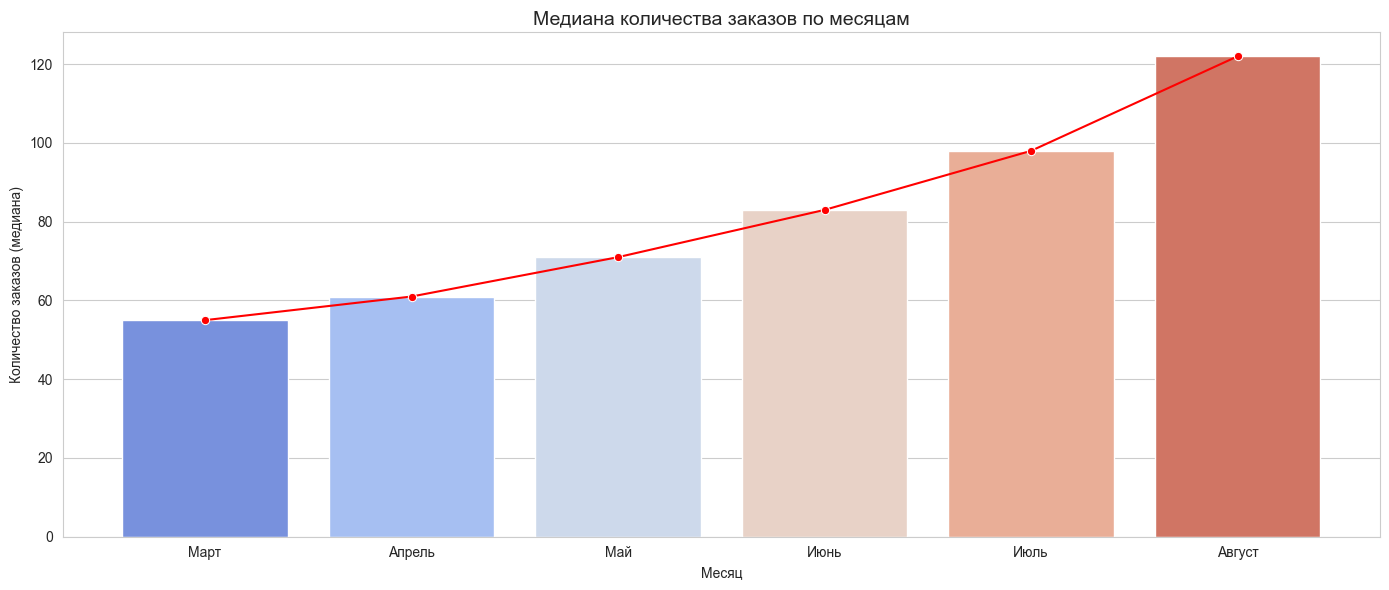

In [287]:
draw_pivot_table(pivot_month, 'Медиана количества заказов по месяцам', 'Месяц',
                 label_dict={3: 'Март',
                             4: 'Апрель',
                             5: 'Май',
                             6: 'Июнь',
                             7: 'Июль',
                             8: 'Август'})


In [288]:
# Создаем сводную таблицу по дням
pivot_day = df.pivot_table(index='day', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_day

,median,sum,count
,num_orders,num_orders,num_orders
day,,,
1,70.5,10418,144
2,71.5,11053,144
3,65.0,10525,144
4,72.0,10437,144
5,65.0,9931,144
6,73.5,11245,144
7,73.5,10919,144
8,77.5,11182,144


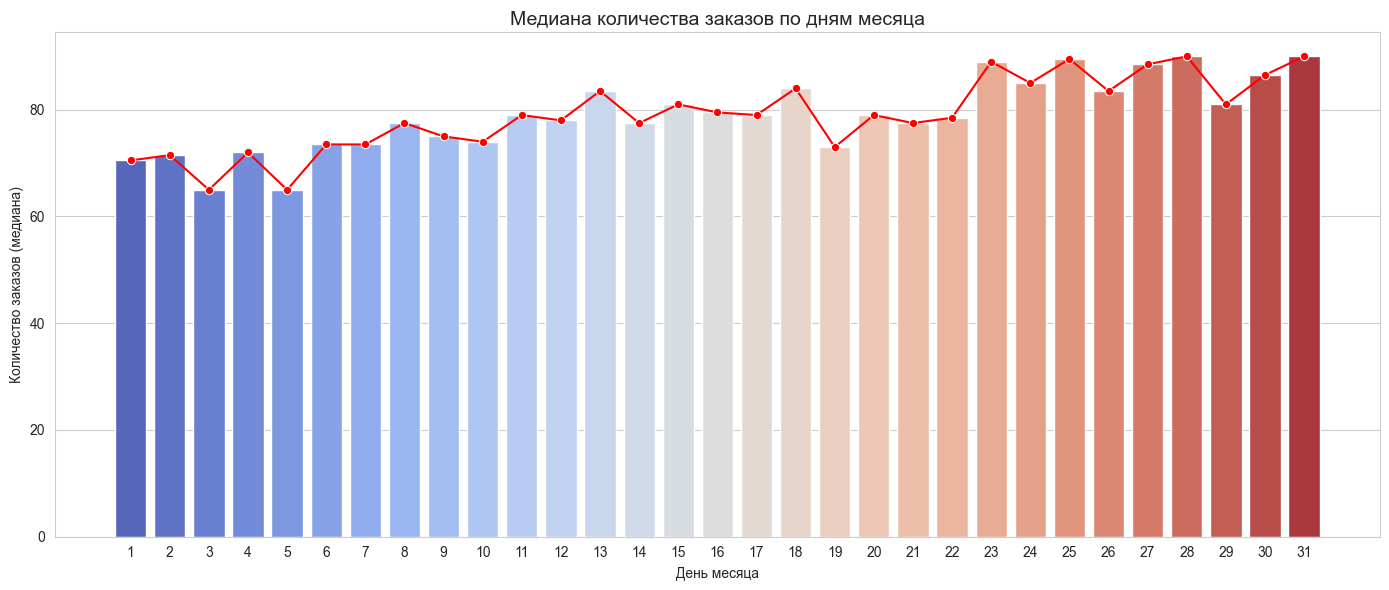

In [289]:
draw_pivot_table(pivot_day, 'Медиана количества заказов по дням месяца', 'День месяца')

In [290]:
# Создаем сводную таблицу по дням недели
pivot_day_of_week = df.pivot_table(index='day_of_week', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_day_of_week

,median,sum,count
,num_orders,num_orders,num_orders
day_of_week,,,
0,81.5,56314,624
1,72.5,48055,624
2,80.0,52263,624
3,78.0,55508,648
4,87.0,59059,648
5,76.0,52321,624
6,75.5,49291,624


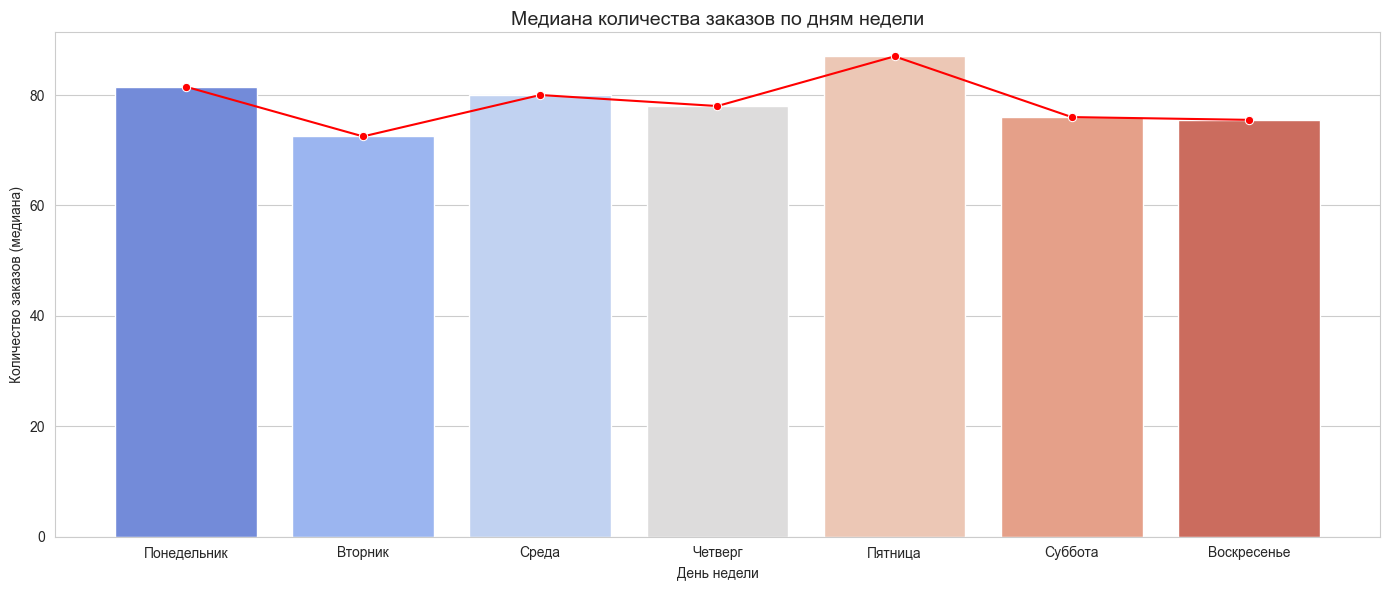

In [291]:
draw_pivot_table(pivot_day_of_week, 'Медиана количества заказов по дням недели', 'День недели',
                 label_dict={0: 'Понедельник',
                             1: 'Вторник',
                             2: 'Среда',
                             3: 'Четверг',
                             4: 'Пятница',
                             5: 'Суббота',
                             6: 'Воскресенье'})

In [292]:
# Создаем сводную таблицу по дням недели
pivot_hour = df.pivot_table(index='hour', values='num_orders', aggfunc=['median', 'sum', 'count'])

# Выводим сводную таблицу
pivot_hour

,median,sum,count
,num_orders,num_orders,num_orders
hour,,,
0,142.0,26570,184
1,93.5,19203,184
2,104.5,20805,184
3,96.5,18772,184
4,83.0,15991,184
5,37.5,7844,184
6,19.0,4632,184
7,27.0,5386,184


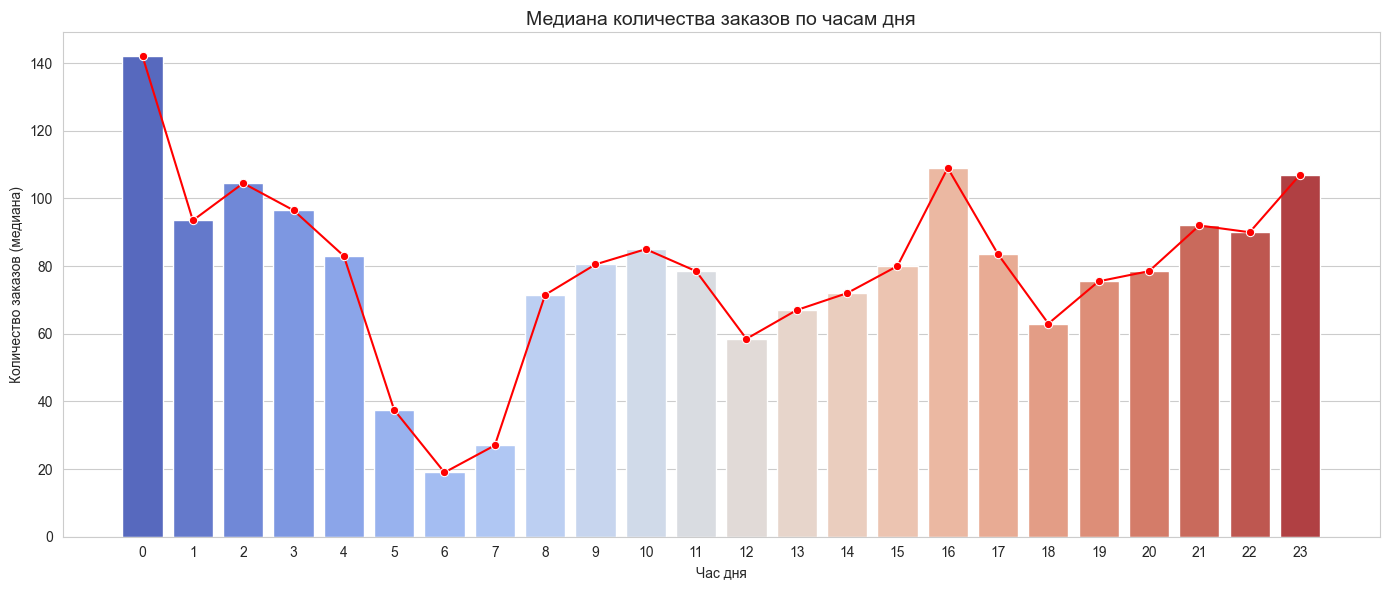

In [293]:
draw_pivot_table(pivot_hour, 'Медиана количества заказов по часам дня', 'Час дня')

In [294]:
# Удаляем ненужные датафреймы
del (
    pivot_month,
    pivot_day,
    pivot_day_of_week,
    pivot_hour
)

### Выводы:

В данных пресутсвуют выбросы, однако это не ошибка системы, а просто высокая нагруженность. Например, одновременный прилет большого количества рейсов в аэропорт, что приводит к большому количеству заказов такси. Количество заказов такси в час варьируется от 0 до 200 (в среднем 50-90 заказов).

Мы создали сводные таблицы по месяцам, дням, дням недели, и часам дня. Количество заказов не особо зависит от дня месяца или дня недели. Однако с приближением лета количество заказов такси сильно увеличивается, что потенциально связано с тем, что летом чаще берут отпуска. Такси чаще заказывают в ночные часы (23-04). Меньше всего такси заказываю в утренние часы (05-08).
В каждом месяце/дне/дне недели/часу количество записей примерно одинаковое, тут никакого дисбаланса нет.

## Корреляционный анализ:

Выведем матрицу корреляции, чтобы понять, какой из признаков больше всего влияет на таргет. Так же проверим данные на наличие мультиколлинеарности, чтобы избежать проблем при обучении модели.

In [295]:
num_cols = ['num_orders']

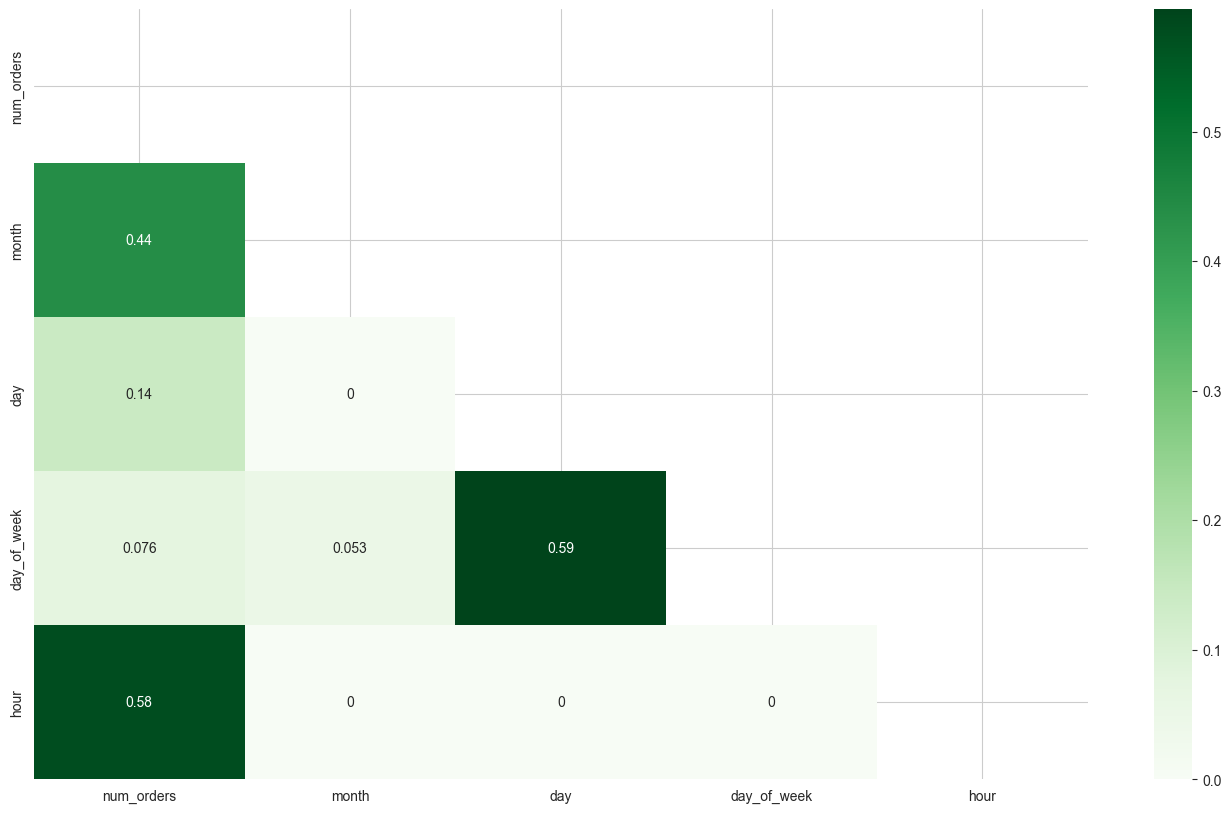

In [296]:
plt.figure(figsize=(17, 10))

# Рисуем матрицу корреляции
sns.heatmap(df.phik_matrix(interval_cols=num_cols),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(
                df.phik_matrix(interval_cols=num_cols),
                dtype=bool)))

plt.show()

В признаках нет мультиколлинеарности, а больше всего таргет коррелирует с часом дня. Околонулевая корреляция наблюдается с признаком "день недели". Удалим этот признак и создадим новые:
- `is_weekend` - признак, является ли день выходным (суббота или воскресенье)
- `is_night` - признак, является ли час ночным (с 21:00 до 04:00)
- `is_morning` - признак, является ли час утренним (с 05:00 до 08:00)
- `lag_n` - Признак, который подскажет, будет ли функция уменьшаться или увеличиваться
- `rolling_mean` - Скользящее среднее за n часов.

### Создание новых признаков:

Создадим новые признаки, которые мы описали выше. Для создания признаков `lag_n` и `rolling_mean` напишем функцию, чтобы можно было менять параметры `n` и `window_size`.

In [297]:
# Выделяем выходные
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

# Удаляем признак с околонулевой корреляцией
df = df.drop('day_of_week', axis=1)

# Создаем новые категориальные признаки:
df['is_night'] = df['hour'].apply(lambda x: 1 if x in [23, 0, 1, 2, 3, 4] else 0)
df['is_morning'] = df['hour'].apply(lambda x: 1 if x in range(5, 8) else 0)

# Выводим датасет
df

,num_orders,month,day,hour,is_weekend,is_night,is_morning
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,0,0,1,0
2018-03-01 01:00:00,85,3,1,1,0,1,0
2018-03-01 02:00:00,71,3,1,2,0,1,0
2018-03-01 03:00:00,66,3,1,3,0,1,0
2018-03-01 04:00:00,43,3,1,4,0,1,0
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,19,0,0,0
2018-08-31 20:00:00,154,8,31,20,0,0,0
2018-08-31 21:00:00,159,8,31,21,0,0,0


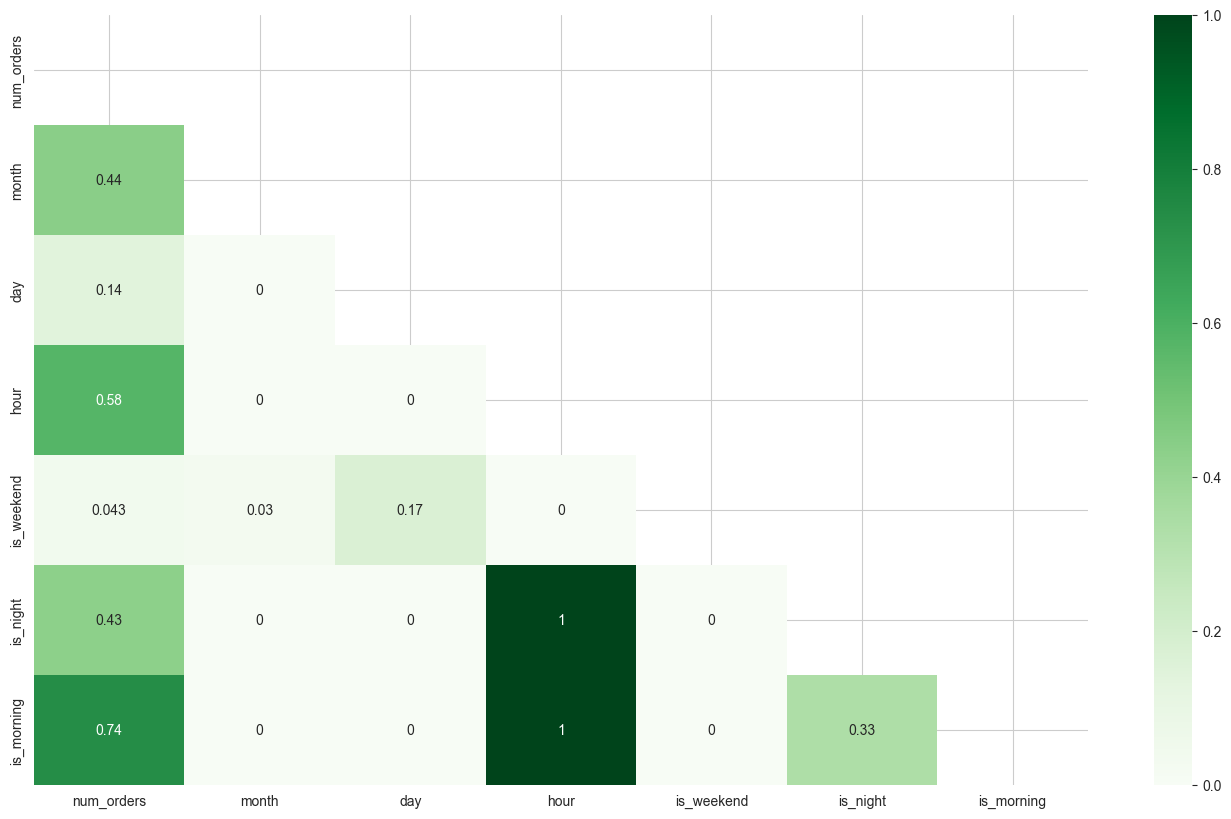

In [298]:
plt.figure(figsize=(17, 10))

# Рисуем матрицу корреляции перед добавлением lag_n и rolling_mean, потому что они будут зависеть от параметров n и window_size
sns.heatmap(df.phik_matrix(interval_cols=num_cols),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(
                df.phik_matrix(interval_cols=num_cols),
                dtype=bool)))

plt.show()

Так как у нас появилась мультиколлинеарность признака `hour` с признаками `is_night` и `is_morning`, то удалим его. Новые признаки показывают себя чуть лучше, чем оригинальный, потому удалим именно его

In [299]:
# Удаляем признак `hour`
df = df.drop('hour', axis=1)

In [300]:
def create_lag_and_rolling(df: pd.DataFrame, n: int = 2, window_size: int = 2) -> pd.DataFrame:
    """
    Функция для создания признаков lag_n и rolling_mean.

    :param df: Датафрейм с данными
    :param n: Количество отстающих значений для lag_n
    :param window_size: Размер окна для скользящего среднего
    :return: Датафрейм с новыми признаками
    """
    # Создаем признак rolling_mean
    df[f'rolling_mean_{window_size}'] = df['num_orders'].shift(1).rolling(window=window_size).mean()

    # Создаем признак lag_n
    for i in range(1, n + 1):
        df[f'lag_{i}'] = df['num_orders'].shift(i)

    return df

In [301]:
# Применяем функцию
df = create_lag_and_rolling(df, n=2, window_size=6)

# Выводим датасет
df

,num_orders,month,day,is_weekend,is_night,is_morning,rolling_mean_6,lag_1,lag_2
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,1,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,0,1,0,NaN,124.0,NaN
2018-03-01 02:00:00,71,3,1,0,1,0,NaN,85.0,124.0
2018-03-01 03:00:00,66,3,1,0,1,0,NaN,71.0,85.0
2018-03-01 04:00:00,43,3,1,0,1,0,NaN,66.0,71.0
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,0,0,0,172.666667,207.0,217.0
2018-08-31 20:00:00,154,8,31,0,0,0,167.666667,136.0,207.0
2018-08-31 21:00:00,159,8,31,0,0,0,171.166667,154.0,136.0


### Вывод:

В признаках нет мультиколлинеарности, а больше всего таргет коррелирует с часом дня. Околонулевая корреляция наблюдается с признаком "день недели". Удалим этот признак и создадим новые:
- `is_weekend` - признак, является ли день выходным (суббота или воскресенье)
- `is_night` - признак, является ли час ночным (с 23:00 до 04:00)
- `is_morning` - признак, является ли час утренним (с 05:00 до 08:00)
- `lag_n` - Признак, который подскажет, будет ли функция уменьшаться или увеличиваться
- `rolling_mean` - Скользящее среднее за n часов.

Мы так же удалили признак `hour`, так как он коррелирует с новыми признаками `is_night` и `is_morning`.